[![Roboflow Notebooks](https://media.roboflow.com/notebooks/template/bannertest2-2.png?ik-sdk-version=javascript-1.4.3&updatedAt=1672932710194)](https://github.com/roboflow/notebooks)

# Fine-tune PaliGemma2 on Object Detection Dataset

---

[![GitHub](https://badges.aleen42.com/src/github.svg)](https://github.com/google-research/big_vision/blob/main/big_vision/configs/proj/paligemma/README.md)
[![arXiv](https://img.shields.io/badge/arXiv-2412.03555-b31b1b.svg)](https://arxiv.org/abs/2412.03555)

PaliGemma 2 is built by combining the SigLIP-So400m vision encoder with the more recent and capable language models from the Gemma 2 family.

![PaliGemma2 Figure.1](https://storage.googleapis.com/com-roboflow-marketing/notebooks/examples/paligemma2-1.png)

The authors use a 3-stage training approach similar to the original PaliGemma. In stage 1, they combine the pretrained vision and language model components and train them jointly on a multimodal task mixture. In stage 2, they train the models at higher resolutions of 448px^2 and 896px^2. In stage 3, they fine-tune the models on the target transfer tasks.

PaliGemma 2 models outperform the original PaliGemma at the same resolution and model size. Increasing the model size and resolution generally improves performance across a wide range of tasks, but the benefits differ depending on the task. Some tasks benefit more from increased resolution, while others benefit more from a larger language model.

![PaliGemma2 Figure.2](https://storage.googleapis.com/com-roboflow-marketing/notebooks/examples/paligemma2-2.png)

Notebook requires A100 with 40GB of VRAM to train.

## Setup

### Configure your API keys

To fine-tune PaliGemma2, you need to provide your HuggingFace Token and Roboflow API key. Follow these steps:

- Open your [`HuggingFace Settings`](https://huggingface.co/settings) page. Click `Access Tokens` then `New Token` to generate new token.
- Go to your [`Roboflow Settings`](https://app.roboflow.com/settings/api) page. Click `Copy`. This will place your private key in the clipboard.
- In Colab, go to the left pane and click on `Secrets` (🔑).
    - Store HuggingFace Access Token under the name `HF_TOKEN`.
    - Store Roboflow API Key under the name `ROBOFLOW_API_KEY`.

### Select the runtime

Let's make sure that we have access to GPU. We can use `nvidia-smi` command to do that. In case of any problems navigate to `Edit` -> `Notebook settings` -> `Hardware accelerator`, set it to `T4 GPU`, and then click `Save`.

In [2]:
!nvidia-smi
import os
os.environ["CUDA_VISIBLE_DEVICES"]="0,1"   #,1"

Mon Oct 13 03:32:15 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 580.82.07              Driver Version: 580.82.07      CUDA Version: 13.0     |
+-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 3090        On  |   00000000:43:00.0 Off |                  N/A |
| 30%   26C    P8             19W /  350W |       1MiB /  24576MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [3]:
os.environ["TOKENIZERS_PARALLELISM"] = "false"

### Download dataset from Roboflow Universe

To fine-tune PaliGemma2, prepare your dataset in JSONL format. You can use Roboflow to easily convert any dataset into this format.

In [4]:
#!pip install -q peft bitsandbytes transformers==4.47.0 tf-keras
!rsync -a --progress /data/lmbraid19/argusm/datasets/indoorCVPR_09.tar /tmp/ && mkdir -p /tmp/indoorCVPR && tar -xf /tmp/indoorCVPR_09.tar -C /tmp/indoorCVPR
!rsync -a --progress /work/dlclarge2/zhangj-zhangj-CFM/data/training2 /tmp/
!file /tmp/indoorCVPR
!file /tmp/training2

sending incremental file list
indoorCVPR_09.tar
  2,592,010,240 100%  420.39MB/s    0:00:05 (xfr#1, to-chk=0/1)
sending incremental file list
training2/
training2/20251003_042340.h5
117,797,583,271 100%  178.03MB/s    0:10:31 (xfr#1, to-chk=3/5)
training2/20251003_042340.json
          3,854 100%    7.48kB/s    0:00:00 (xfr#2, to-chk=2/5)
training2/args.txt
            505 100%    0.98kB/s    0:00:00 (xfr#3, to-chk=1/5)
training2/run.log
      1,106,496 100%    1.88MB/s    0:00:00 (xfr#4, to-chk=0/5)
/tmp/indoorCVPR: directory
/tmp/training2: directory


**NOTE:** Let's read the first few lines of the annotation file and examine the dataset format.

In [5]:
%load_ext autoreload
%autoreload 2
from pathlib import Path
from cvla.data_loader_h5 import H5Dataset
from cvla.data_loader_jsonl import JSONLDataset
from cvla.data_augmentations import augment_image_rgb, RandomizeBackgrounds
from cvla.data_augmentations import complexify_text, DepthAugmentation
from cvla.data_loader_images import ImageFolderDataset
from torchvision import transforms


model_location = Path("/data/lmbraid19/argusm/models")
dataset_location = Path("/tmp/training2")

run_name = "_topview_70000_based"
bg_image_dataset = ImageFolderDataset("/tmp/indoorCVPR/Images", transform=transforms.RandomResizedCrop((448,448)))
randomize_background = RandomizeBackgrounds(p=0.2, background_images=bg_image_dataset)
augment_depth = DepthAugmentation(depth_range=(25, 100), max_delta_depth=35)
train_dataset = H5Dataset(dataset_location, augment_rgbds=randomize_background, augment_rgb=augment_image_rgb, augment_text=complexify_text,
                          augment_depth=augment_depth, return_depth=True)

print("dataset_location:", dataset_location,"samples:", len(train_dataset))

/home/zhangj/miniconda3/envs/mani_skill_clean/lib/python3.12/site-packages/torch/cuda/__init__.py:63: FutureWarning: The pynvml package is deprecated. Please install nvidia-ml-py instead. If you did not install pynvml directly, please report this to the maintainers of the package that installed pynvml for you.
  import pynvml  # type: ignore[import]
/home/zhangj/miniconda3/envs/mani_skill_clean/lib/python3.12/site-packages/sapien/_vulkan_tricks.py:37: UserWarning: Failed to find system libvulkan. Fallback to SAPIEN builtin libvulkan.
  warn("Failed to find system libvulkan. Fallback to SAPIEN builtin libvulkan.")


dataset_location: /tmp/training2 samples: 88244


### Set up and test data loaders


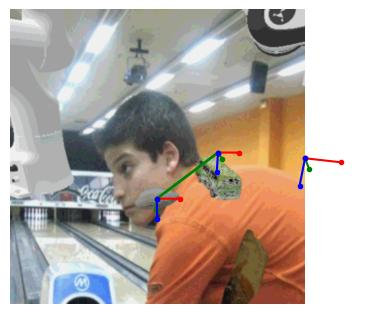
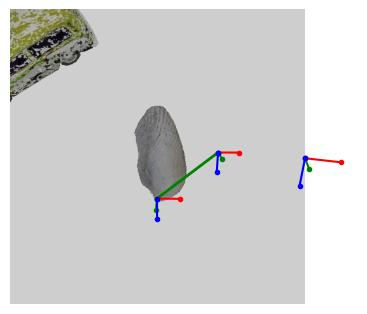
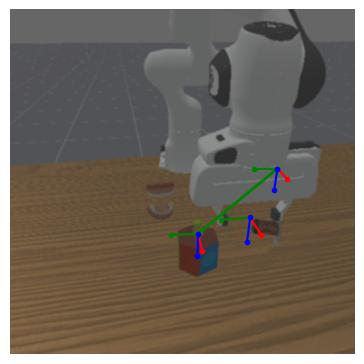
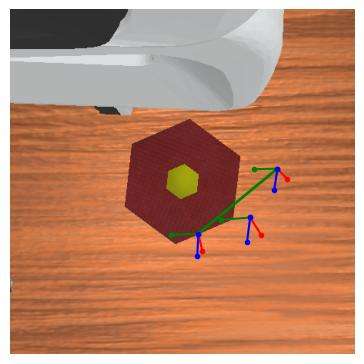
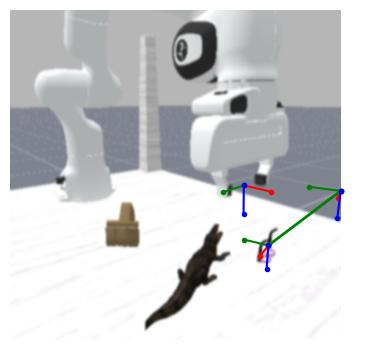
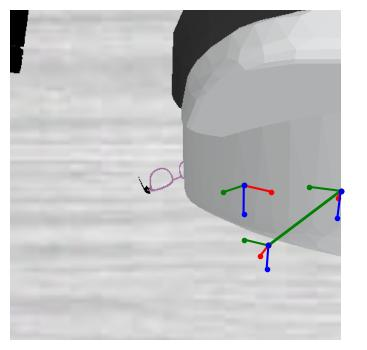
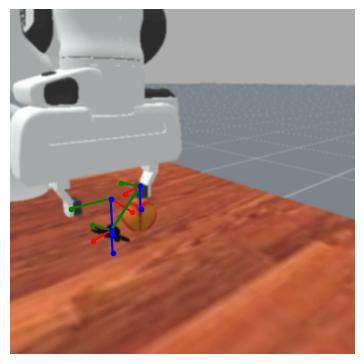
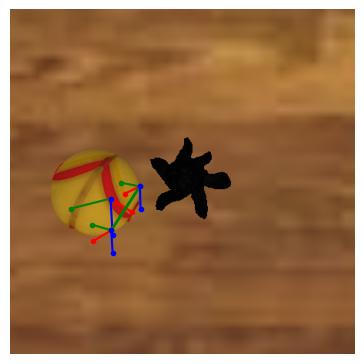
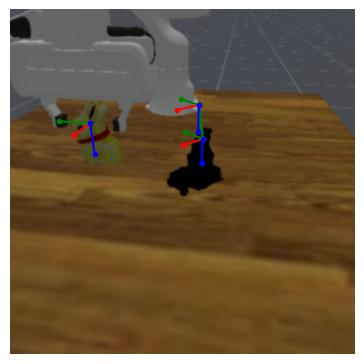
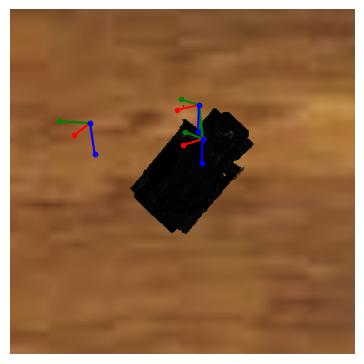
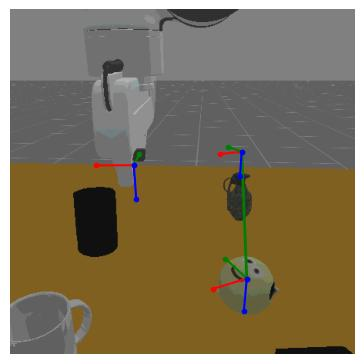
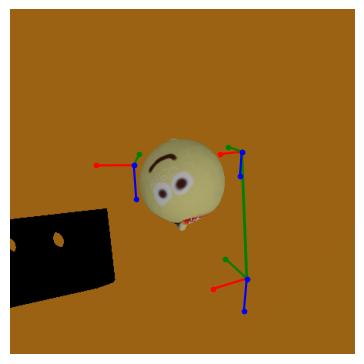

In [6]:
from cvla.utils_vis import render_example
import matplotlib.pyplot as plt

num_samples = 3*2
html_imgs = ""
for i in range(num_samples):
    image, sample = train_dataset[i]
    prefix = sample["prefix"]
    html_imgs += render_example(image[0], label=sample["suffix"], text=prefix, camera=sample["camera"])
    html_imgs += render_example(image[1], label=sample["suffix"], text=prefix, camera=sample["camera"])

plot_images = True
if plot_images:
    from IPython.display import display, HTML
    display(HTML(html_imgs))
    

### Load PaliGemma2 model

**NOTE:** PaliGemma2 offers 9 pre-trained models with sizes of `3B`, `10B`, and `28B` parameters, and resolutions of `224`, `448`, and `896` pixels. In this tutorial, I'll be using the [`google/paligemma2-3b-pt-448`](https://huggingface.co/google/paligemma2-3b-pt-448) checkpoint. Resolution has a key impact on the mAP of the trained model, and it seems that `448` offers the most optimal balance between performance and compute resources required to train the model.

In [ ]:
# from huggingface_hub import notebook_login
# notebook_login()

In [7]:
from transformers import PaliGemmaProcessor, PaliGemmaForConditionalGeneration
import torch

# setting device on GPU if available, else CPU
print("cuda visible devices:", os.environ["CUDA_VISIBLE_DEVICES"])
devices_good = sorted((int(x) for x in os.environ["CUDA_VISIBLE_DEVICES"].split(",")))
DEVICE = torch.device('cuda')
print(DEVICE)
print('Using device:', DEVICE)
print("Good devices", devices_good)

TORCH_DTYPE = torch.bfloat16
# use checkpoint
#LOCAL_CHECKPOINT = "/data/lmbraid19/argusm/models/_text_lr3e-05xyzrotvec-cam-512xy256d_2025-04-23_12-03-48/checkpoint-4687"

#fine-tune directly on paligemma2
MODEL_NAME = "google/paligemma2-3b-pt-224"

processor = PaliGemmaProcessor.from_pretrained("google/paligemma2-3b-pt-224")
model = PaliGemmaForConditionalGeneration.from_pretrained(
    #LOCAL_CHECKPOINT,
    MODEL_NAME,
    torch_dtype=TORCH_DTYPE,
    device_map="auto",
    attn_implementation='eager'
).to("cuda") 


cuda visible devices: 0,1
cuda
Using device: cuda
Good devices [0, 1]


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [8]:
import random
def augment_suffix(suffix):
    parts = suffix.split(' ; ')
    random.shuffle(parts)
    return ' ; '.join(parts)

def collate_fn(batch):
    images, labels = zip(*batch)
    prefixes = ["<image>" + label["prefix"] for label in labels]
    suffixes = [augment_suffix(label["suffix"]) for label in labels]

    inputs = processor(
        text=prefixes,
        images=images,
        return_tensors="pt",
        suffix=suffixes,
        padding="longest"
    ).to(TORCH_DTYPE).to(DEVICE)

    return inputs

In [9]:
def collate_fn(batch):
    images, labels = zip(*batch)
    prefixes = [label["prefix"] for label in labels]
    suffixes = [augment_suffix(label["suffix"]) for label in labels]
    inputs = processor(
        text=prefixes,
        images=list(images),
        return_tensors="pt",
        suffix=suffixes,
        padding="longest"
    ).to(TORCH_DTYPE)#.to(DEVICE)
    print("prefixes", prefixes)
    return inputs

batch = [train_dataset[i] for i in range(3)]
inputs = collate_fn(batch)
for x in inputs:
    print(x, inputs[x].shape)

You are passing both `text` and `images` to `PaliGemmaProcessor`. The processor expects special image tokens in the text, as many tokens as there are images per each text. It is recommended to add `<image>` tokens in the very beginning of your text. For this call, we will infer how many images each text has and add special tokens.


prefixes ['put the white ribbed shell into the graffiti volkswagen van <loc0516><loc1023><loc0044><seg039><seg068><seg070>', 'put the vibrant hexagonal dreidel in the red can <loc0617><loc0711><loc0053><seg045><seg079><seg089>', 'put the stylish purple eyeglasses in the rustic wooden bracket <loc0543><loc0723><loc0049><seg039><seg076><seg078>']
input_ids torch.Size([3, 544])
token_type_ids torch.Size([3, 544])
attention_mask torch.Size([3, 544])
pixel_values torch.Size([6, 3, 224, 224])
labels torch.Size([3, 544])


In [10]:
inputs["input_ids"]

tensor([[257152, 257152, 257152,  ..., 257088, 257088,      1],
        [257152, 257152, 257152,  ..., 257104, 257114,      1],
        [257152, 257152, 257152,  ..., 257116, 257123,      1]])

In [11]:
def collate_fn(batch):
    images, labels = zip(*batch)
    prefixes = ["<image><image>" + label["prefix"] for label in labels]
    suffixes = [augment_suffix(label["suffix"]) for label in labels]
    images_flat = [img for img_list_x in images for img in img_list_x]
    inputs = processor(
        text=prefixes,
        images=images_flat,
        return_tensors="pt",
        suffix=suffixes,
        padding="longest"
    ).to(TORCH_DTYPE)
    return inputs

batch = [train_dataset[i] for i in range(3)]
inputs = collate_fn(batch)
for x in inputs:
    print(x, inputs[x].shape)

input_ids torch.Size([3, 544])
token_type_ids torch.Size([3, 544])
attention_mask torch.Size([3, 544])
pixel_values torch.Size([6, 3, 224, 224])
labels torch.Size([3, 544])


In [12]:
inputs["input_ids"]

tensor([[257152, 257152, 257152,  ..., 257088, 257088,      1],
        [257152, 257152, 257152,  ..., 257104, 257114,      1],
        [257152, 257152, 257152,  ..., 257116, 257123,      1]])

In [13]:
import numpy as np
def compute_metrics(eval_pred):
    predictions, label_tokens = eval_pred  # Extract predictions and labels
    if isinstance(predictions, tuple):  # Some models return tuples
        predictions = predictions[0]

    # Convert to token indices if necessary (e.g., for text generation models)
    pred_tokens = np.argmax(predictions, axis=-1)  # Assuming logits, take argmax

    pred_texts = processor.tokenizer.batch_decode(pred_tokens[:,-SEQLEN-1:], skip_special_tokens=True)
    label_text = processor.tokenizer.batch_decode(label_tokens[:,-SEQLEN-1:], skip_special_tokens=True)

    print(pred_tokens[:,-SEQLEN-1:])
    print(label_tokens[:,-SEQLEN-1:])
    print(label_text)
    print(pred_texts)
    print()
    return {"accuracy": 0}

## Fine-tune with JAX settings

In [14]:
from transformers import Seq2SeqTrainingArguments
from transformers import Seq2SeqTrainer

for param in model.vision_tower.parameters():
    param.requires_grad = False

for param in model.multi_modal_projector.parameters():
    param.requires_grad = False
    
for name, param in model.named_parameters():
    if param.requires_grad == True:
        if "self_attn" in name:
            param.requires_grad = True
        else:
            param.requires_grad = False

TRAIN_EXAMPLES = len(train_dataset)
BATCH_SIZE = 32
BATCH_SIZE_DEV = 2 # on l40 was 8
GRAD_ACCUM = int(round(BATCH_SIZE / BATCH_SIZE_DEV))
TRAIN_STEPS = (TRAIN_EXAMPLES // BATCH_SIZE)
SEQLEN = 12
SAVE_STEPS = int(TRAIN_STEPS / 15)
SAVE_LIMIT = 5

run_name = "_topview_70000_based"
new_model_location = Path("/work/dlclarge2/zhangj-zhangj-CFM/models")
save_path = new_model_location / (str(Path(dataset_location).stem) + run_name)
print("save_path", save_path)
print("TRAIN_STEPS",TRAIN_STEPS)
print("GRAD_ACCUM", GRAD_ACCUM)

args_jax = Seq2SeqTrainingArguments(
    max_steps=TRAIN_STEPS,
    remove_unused_columns=False,
    per_device_train_batch_size=BATCH_SIZE_DEV,
    gradient_accumulation_steps=GRAD_ACCUM,
    learning_rate=3e-5,  # 1e-5, 2e-5,
    lr_scheduler_type="cosine",
    warmup_ratio=.05,
    generation_max_length=SEQLEN,
    logging_steps=10,
    optim="adafactor",
    save_strategy="steps",
    save_steps=SAVE_STEPS,
    save_total_limit=SAVE_LIMIT,
    output_dir=save_path,
    bf16=True,
    report_to=["tensorboard"],
    dataloader_pin_memory=False,
    dataloader_num_workers=4,
    #dataloader_prefetch_factor=2,
    #eval_strategy="steps",
    #eval_steps=4,
    #per_device_eval_batch_size=BATCH_SIZE_DEV,
    #eval_accumulation_steps=GRAD_ACCUM
)
#gradient_checkpointing=True,
#weight_decay=3e-7,

trainer = Seq2SeqTrainer(
    model=model,
    train_dataset=train_dataset,
    #eval_dataset=train_dataset_small,
    data_collator=collate_fn,
    args=args_jax,
    #compute_metrics=compute_metrics
)

save_path /work/dlclarge2/zhangj-zhangj-CFM/models/training2_topview_70000_based
TRAIN_STEPS 2757
GRAD_ACCUM 16


In [15]:
#only when recover from last time training
last_checkpoint = "/work/dlclarge2/zhangj-zhangj-CFM/models/training2_topview_70000_based/checkpoint-183"
trainer.train(resume_from_checkpoint=last_checkpoint)


There were missing keys in the checkpoint model loaded: ['language_model.lm_head.weight'].


Step,Training Loss
190,3.398100
200,3.398600
210,3.375600
220,3.314500
230,3.281700
240,3.276300
250,3.273100
260,3.220900
270,3.234500
280,3.202600


TrainOutput(global_step=2757, training_loss=2.239264762181063, metrics={'train_runtime': 17468.9515, 'train_samples_per_second': 5.05, 'train_steps_per_second': 0.158, 'total_flos': 7.032929884840134e+17, 'train_loss': 2.239264762181063, 'epoch': 0.9997733556955714})

In [16]:
for key, value in inputs.items():
    if torch.is_tensor(value):
        inputs[key] = value.to(DEVICE)

In [11]:
trainer.train()

Step,Training Loss
10,15.296200
20,13.151700
30,7.894100
40,5.656600
50,4.872800
60,4.385200
70,4.182800
80,3.971300
90,3.833500
100,3.758400


AcceleratorError: CUDA error: unspecified launch failure
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.


In [ ]:
print("Model device:", next(model.parameters()).device)
for k, v in inputs.items():
    if torch.is_tensor(v):
        print(f"  {k}: {v.device}")


In [ ]:
print(next(model.parameters()).device)
print({k: v.device for k, v in inputs.items() if torch.is_tensor(v)})